# Case

Imagine you've just been hired as a Data Analyst to join one of our Data
Squads, responsible for leveraging the products team and operation
team to make better decisions based on data and provide insights
that improve the our stakeholders decisions.

This quarter, your main goal is to help the product team to **increase
the number of contracts signed**, which **has been in steady decline**
since early this year.

1. **What seems to be happening?** Try to understand main bottlenecks along the funnel and raise hypotheses that may have caused each behavior.

    - Os dados do de contratos assinados por visita sugerem que na maioria das vezes, as primeiras visitas não são convertidas em contratos assinados. Isto também é visto no funil de contrato de ofertas de visitas com o **número de inquilinos que fizeram ofertas**. Talvez se os inquilinos fizessem mais visitas, aumentasse a probabilidade de fazer ofertas e, por consequencia, assinar contrato.  Uma outra possibilidade, é causar uma melhor impressão ou um melhor match nas primeiras visitas. Para isso, aumentar a verossimilhança dos anúncios pode ajudar: muitas reviews tem marcações da casa ser diferente do anúncio, não estar tão conservada e/ou ser maior nas fotos. As pessoas estão indo para a visita com expectavas diferentes do que vão encontrar. Ao mostrar anúncios que retraram melhor a condição da casa, pode resultar nas pessoas com as expextativas alinhadas na primeira visita, aumente a probabilidade de fazer uma oferta e assinar contrato. 
    - Além disso, o **número de casas visitadas** parece ser um outro bottleneck, que limita todo o funil abaixo**: número de ofertas, de inquilinos que fizeram ofertas e, consequentemente, o número de contratos. Essa é a maior separação no gráfico de funil.<br><br>
    


2. **Is there any other information that would be relevant to your analysis?** Why would it be relevant? What would be the outputs with the new data available?
    - In the reviews, would be helpful to know which visits resulted in contracts. 
    - How many visits each tenant did up to that point.
    That is, would be helfull to have the other two tables at visit granularity.
    Com esses dados adicionais poderíamos conectar as informações das três tabelas fornecidas e fazer obter insights mais precisos e aprofundados.
    <br><br> 
  


3. **Can you think of 3 other analysis that could help our stakeholder with our quarter goal?** Please describe the analysis as well as the benefits of each one for our
    stakeholders. Try to explain how the idea could be implemented, connecting strategy 
    with product team and how these analysis can make impact in our stakeholders decisions.

    - Analisar a qualidade dos anúncios e o que fazer para melhor alinhar as expectativas dos clientes na primeira visita.
    - Analisar como melhorar os filtros de anúncios/recomendação de anúncios, para que o cliente consiga um 'match' mais adequado e, assim, aumenta a probabilidade de assinar contrato nas primeiras visitas.
    - Analisar/Entender o que faz o número de casas visitas ser menor. Talvez, novamente esteja relacionada com a qualidade dos anúncios, localidade, etc.


# Loading data

In [1]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import psycopg2
from tqdm.cli import tqdm
import janitor

# tenant_reviews
TABLES_NAMES = ['tenant_reviews_clean','visits_contracts','visits_offers_contracts']

In [2]:
def load_tables_sql(tables_names = TABLES_NAMES):
    print("loading tables from sql")
    conn = psycopg2.connect(
        dbname="quintoandar",
        host="db.candidates.sandbox.data.quintoandar.com.br",
        port="5432",
        user="data-analytics",
        password="97PGf56yWCWa",
        client_encoding='UTF8'
    )
    query = "select * from {}"

    tables = {}
    try:
        for table in tqdm(tables_names):
            df = pd.read_sql(query.format(table), con=conn)
            tables[table] = df
            print(table, df.shape)
    finally:
        conn.close()
    
    return tables


def load_tables_parquet(tables = TABLES_NAMES):
    print("loading tables from parquet")
    parquet_tables = {}
    for table in tables:
        df = pd.read_parquet(f'data/{table}.parquet')
        parquet_tables[table] = df
        print(table, df.shape)
        #print(f"{table}:shape of differences: {df.compare(df2).shape}")

    return parquet_tables


load_sql = False

if load_sql:
    tables = load_tables_sql()
    # for table, df in tables.items():
    #     df.to_parquet(f'data/{table}.parquet')
else:
    tables = load_tables_parquet()

loading tables from parquet
tenant_reviews_clean (13470, 18)
visits_contracts (15, 3)
visits_offers_contracts (8, 7)


In [3]:
#dftenant_reviews = tables['tenant_reviews']
dftenant_reviews_raw = tables['tenant_reviews_clean']
dfvisits_contracts = tables['visits_contracts']
dfvisits_offers_contracts_raw = tables['visits_offers_contracts']

# Tratamentos

In [4]:
# data treatments
dftenant_reviews = dftenant_reviews_raw.copy()

dftenant_reviews["visit_date"] = pd.to_datetime(dftenant_reviews["visit_date"])

dftenant_reviews['total'] = True

# order review categories
review_dtype = pd.CategoricalDtype(
    ["Visita não aconteceu.", "1", "2", "3", "4", "5", "VaiNegociar"], ordered=True
)
dftenant_reviews["review"] = dftenant_reviews["review"].replace(
    "EntradaNaoAutorizada", "Visita não aconteceu."
).astype(review_dtype)

# review dummies
dftenant_reviews = pd.concat(
    [dftenant_reviews, pd.get_dummies(dftenant_reviews["review"], prefix="review")],
    axis=1,
)

dftenant_reviews['visit_date_ym'] = dftenant_reviews['visit_date'].dt.strftime('%b')

#dftenant_reviews.columns

In [5]:
# grouping columns

flags = [
    "building",
    "conservation",
    "size",
    "price",
    "location",
    "total",
]


neg_flags = [
    
    "did_not_like_the_location",
    "expected_a_better_preserved_property",
    "bigger_in_photos",
    "different_from_the_listing",
    "total",
]

others = [
    # "visit_date",
    # "day",
    # "time",
    # "house_id",
    # "neighbourhood",
    # "visitor",
    # "agent",
    # "review",
    # "others",
]

dummies = list(dftenant_reviews.columns[dftenant_reviews.columns.str.startswith("review_")])


cols_other = [c for c in dftenant_reviews.columns if c not in flags+neg_flags+dummies]


#dftenant_reviews.groupby(flags)[['visitor']].count().sort_values(flags)

def fmtr(args):
    x,y=args
    return f"{x:.0f} ({y:.0%})"



In [6]:
# dfvisits_offers_contracts
months_cat = ['jan', 'fev', 'mar', 'abr', 'mai', 'jun', 'jul', 'ago']
months_cat = pd.CategoricalDtype(months_cat, ordered=True)

funnel_cat = [
    "visits",
    "tenant_that_visited",
    "visited_houses",
    "offers",
    "tenants_that_made_offers",
    "contracts",
]
funnel_cat = pd.CategoricalDtype(reversed(funnel_cat), ordered=True)

dfvisits_offers_contracts = pd.melt(dfvisits_offers_contracts_raw,id_vars=["month"])

dfvisits_offers_contracts['month'] = dfvisits_offers_contracts['month'].astype(months_cat)
dfvisits_offers_contracts['variable'] = dfvisits_offers_contracts['variable'].astype(funnel_cat)

# EDA

## Contratos de visitas

Para começar, vamos explorar a tabela de contratos de visitas.

O gráfico abaixo mostra que o número inquilinos que não assinaram cai (quase que) exponencialmente com o número de visitas. Enquanto que o número de inquilinos que assinaram também decresce, mas num  .

Se considerarmos a proporção de inquilinos que assinaram como uma estimativa de probabilidade, então
**a probabilidade do inquilino assinar parece crescer com o número de visitas até a quinta vista e depois decrescer.**

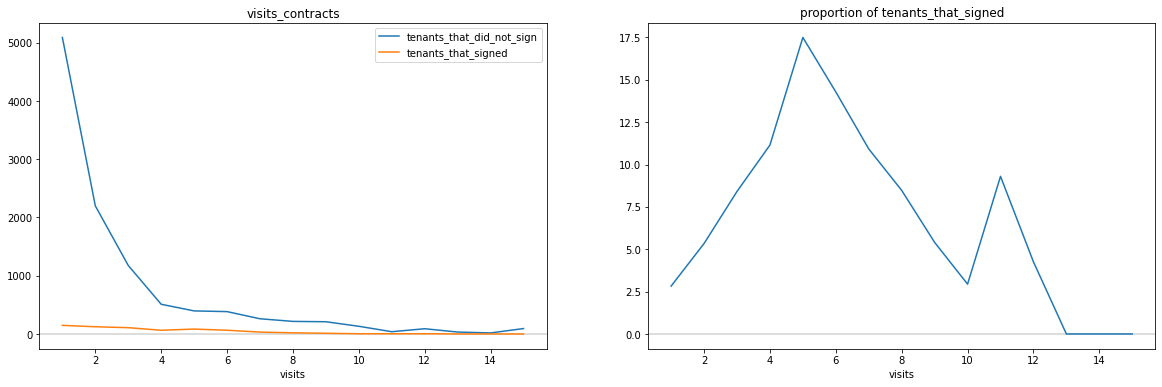

In [7]:
# dfvisits_contracts
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=2, figsize=(20, 6))

df = dfvisits_contracts.set_index('visits').copy()

df.plot(ax=axs[0], title='visits_contracts')
axs[0].axhline(0, c='lightgray', zorder=-10)

df['prop_tenants_that_signed'] = df['tenants_that_signed'] / df.sum(axis=1) * 100
df['prop_tenants_that_signed'].plot(ax=axs[1], title='proportion of tenants_that_signed')
axs[1].axhline(0, c='lightgray', zorder=-10)
plt.show()

## Funil de contratos de ofertas de visitas

A figura mostra dois gráficos: no lado esquerdo, a tendências das variáveis ao longo do tempo e, no lado direito, as correlações (lineares) dessas variáveis entre si.

Como mencionado no case, o número de contratos apresenta uma tendência de queda. 

O número de inquilinos que visitaram e o número de visitas mostram-se *negativamente* correlacionadas com o número de contratos.
Enquanto que o número de inquilinos que fizeram uma oferta é *positivamente* correlacionado com o número de contratos.

O bottleneck que parece ser o mais grave acontece no número de casas visitadas. O **número de casas visitadas parece estar limitando o funil abaixo**: número de ofertas, de inquilinos que fizeram ofertas e, consequentemente, o número de contratos.

Um outro bottleneck parece ser o número de **inquilinos que fizeram ofertas**.


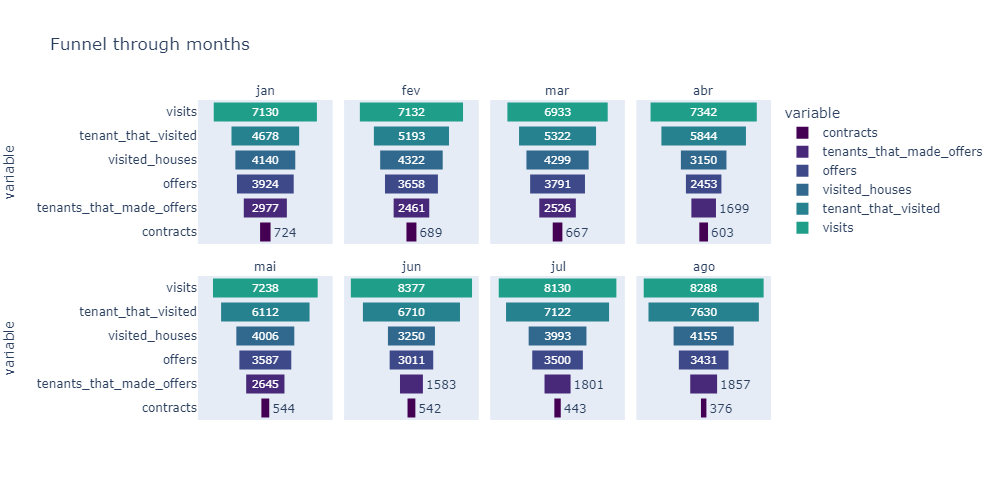

In [38]:
import plotly.express as px

fig = px.funnel(
    dfvisits_offers_contracts,
    x="value",
    y="variable",
    color="variable",
    color_discrete_sequence=px.colors.sequential.Viridis,
    category_orders={"variable": funnel_cat.categories},
    facet_col="month",
    facet_col_wrap=4,
    facet_row_spacing=0.1,
    title='Funnel through months',
    width=1000, height=500
)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[1]))
#fig.for_each_trace(lambda t: t.update(name=t.name.split("=")[1]))
#fig.show()

from IPython.display import Image

Image(fig.to_image())


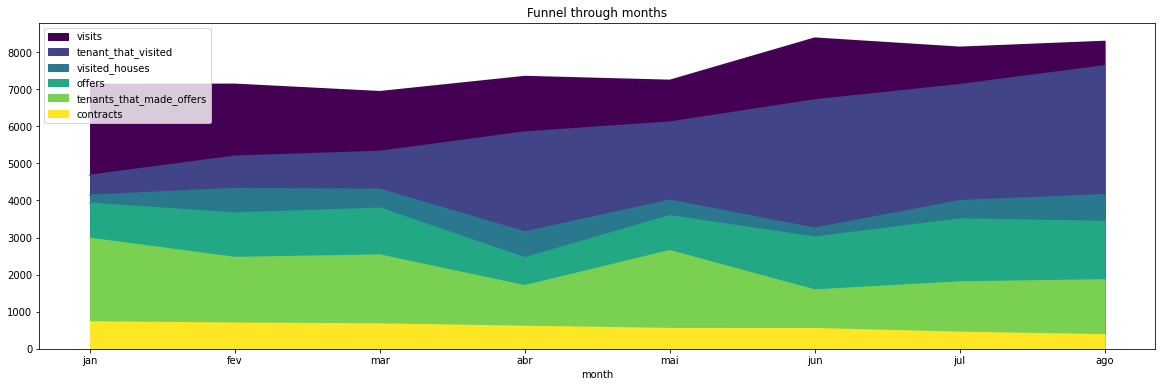

In [9]:
# dfvisits_offers_contracts
from plot_corr import plot_corr
fig, ax = plt.subplots(figsize=(20, 6))
# plot1
dfvisits_offers_contracts_raw.set_index('month').plot.area(ax=ax, title='Funnel through months', stacked=False, alpha=1, cmap='viridis')
plt.show()


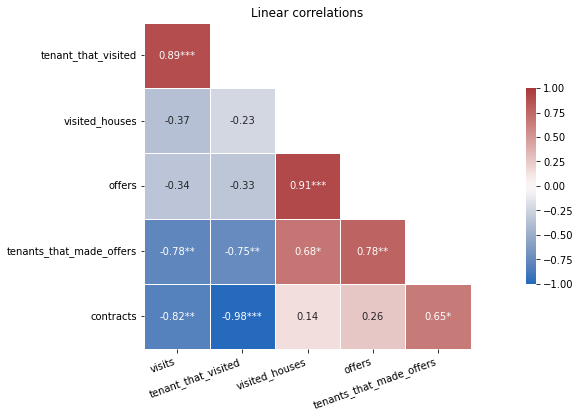

In [10]:
# dfvisits_offers_contracts
from plot_corr import plot_corr

fig, ax = plt.subplots(figsize=(20, 6))

plot_corr(dfvisits_offers_contracts_raw, ax=ax)
ax.set_title('Linear correlations')
plt.show()

## Review dos inquilinos

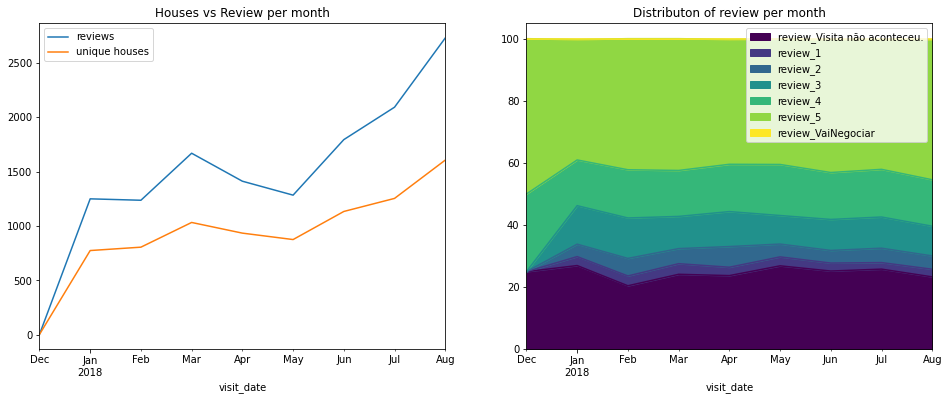

In [11]:
month = pd.Grouper(key='visit_date', freq='1M')

# dftenant_reviews
fig,axs=plt.subplots(ncols=2,figsize=(16,6))

#plot1
ax=axs[0]
dftenant_reviews.groupby(month)['total'].sum().plot(title="Houses vs Review per month", label='reviews', ax=ax)
dftenant_reviews.groupby(month).house_id.nunique().plot(label='unique houses', ax=ax)
ax.legend()

#plot2
reviews_per_month = dftenant_reviews.groupby(month)[dummies+['total']]
(reviews_per_month.mean()* 100).iloc[:, :-1].plot.area(cmap='viridis', title='Distributon of review per month', ax=axs[1])

#display(reviews_per_month.agg(lambda x: (x.sum(),x.mean())).pipe(lambda x, fmt: x.set_index(x.index.strftime(fmt)), "%Y-%m").T.style.format(fmtr))

# tabela numero de reviews por mes por tipo de review
# (
#     dftenant_reviews.groupby(
#         [pd.Grouper(key="visit_date", freq="1M"), "review"], dropna=True
#     )["total"]
#     .count()
#     .unstack(1)
#     .rename_axis(columns="reviews por mes")
#     .pipe(lambda x: x.set_axis(x.index.strftime("%b"), axis=0))
# )

plt.show()

## Tenant's opinions

In [12]:
# positive opinions
flags_per_review = dftenant_reviews.groupby('review')[flags].agg(lambda x: (x.sum(),x.mean())).T
display(flags_per_review.rename_axis(index='positive opinions (liked the ...)').style.format(fmtr))

flags_per_review = dftenant_reviews.groupby('visit_date_ym', sort=False)[flags].agg(lambda x: (x.sum(),x.mean())).T
display(flags_per_review.rename_axis(index='positive opinions per month').style.format(fmtr))

review,Visita não aconteceu.,1,2,3,4,5,VaiNegociar
positive opinions (liked the ...),,,,,,,
building,0 (0%),0 (0%),0 (0%),0 (0%),0 (0%),2839 (50%),0 (0%)
conservation,0 (0%),0 (0%),0 (0%),0 (0%),0 (0%),3609 (64%),6 (20%)
size,0 (0%),0 (0%),0 (0%),0 (0%),0 (0%),3581 (63%),9 (30%)
price,0 (0%),0 (0%),0 (0%),0 (0%),0 (0%),2477 (44%),12 (40%)
location,0 (0%),0 (0%),0 (0%),0 (0%),0 (0%),4514 (80%),11 (37%)
total,3302 (100%),364 (100%),635 (100%),1416 (100%),2050 (100%),5673 (100%),30 (100%)


visit_date_ym,Dec,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug
positive opinions per month,,,,,,,,,
building,0 (0%),253 (20%),275 (22%),346 (21%),286 (20%),254 (20%),381 (21%),431 (21%),613 (22%)
conservation,0 (0%),300 (24%),335 (27%),449 (27%),356 (25%),339 (26%),487 (27%),553 (26%),796 (29%)
size,0 (0%),303 (24%),336 (27%),468 (28%),365 (26%),334 (26%),473 (26%),542 (26%),769 (28%)
price,1 (25%),225 (18%),224 (18%),307 (18%),244 (17%),227 (18%),316 (18%),382 (18%),563 (21%)
location,1 (25%),393 (31%),418 (34%),584 (35%),467 (33%),393 (31%),621 (35%),690 (33%),958 (35%)
total,4 (100%),1250 (100%),1237 (100%),1669 (100%),1412 (100%),1284 (100%),1794 (100%),2092 (100%),2728 (100%)


In [13]:
# negative opinions
#dftenant_reviews.groupby('review')[flags].apply(lambda x: x.sum().astype(str) + " (" + (x.mean()*100).round(0).astype(str)+"%)").T
neg_flags_per_review = dftenant_reviews.groupby('review')[neg_flags].agg(lambda x: (x.sum(),x.mean())).T
display(neg_flags_per_review.rename_axis(index='Negative opinions').style.format(fmtr))


review,Visita não aconteceu.,1,2,3,4,5,VaiNegociar
Negative opinions,,,,,,,
did_not_like_the_location,1 (0%),64 (18%),118 (19%),226 (16%),298 (15%),0 (0%),3 (10%)
expected_a_better_preserved_property,0 (0%),236 (65%),376 (59%),720 (51%),743 (36%),0 (0%),2 (7%)
bigger_in_photos,0 (0%),92 (25%),210 (33%),468 (33%),678 (33%),0 (0%),10 (33%)
different_from_the_listing,0 (0%),96 (26%),79 (12%),93 (7%),38 (2%),0 (0%),2 (7%)
total,3302 (100%),364 (100%),635 (100%),1416 (100%),2050 (100%),5673 (100%),30 (100%)


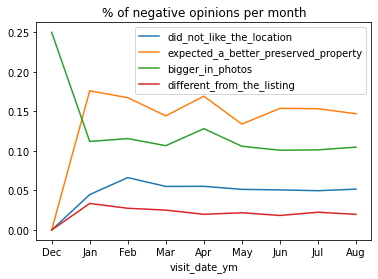

In [14]:
# negative opinions per month
neg_opn_per_month = dftenant_reviews.groupby('visit_date_ym', sort=False)[neg_flags[:-1]].mean()
neg_opn_per_month.plot(title="% of negative opinions per month")
plt.show()

In [15]:
# alguma review negativa?
dftenant_reviews['sum_neg_opn'] = dftenant_reviews[neg_flags[:-1]].sum(axis=1)

dftenant_reviews.groupby('review')[['sum_neg_opn']].agg(['mean','sum', 'count'])

sum_neg_opn            
                             mean   sum count
review                                       
Visita não aconteceu.    0.000303     1  3302
1                        1.340659   488   364
2                        1.233071   783   635
3                        1.064266  1507  1416
4                        0.857073  1757  2050
5                        0.000000     0  5673
VaiNegociar              0.566667    17    30

## Review changes with visit time?

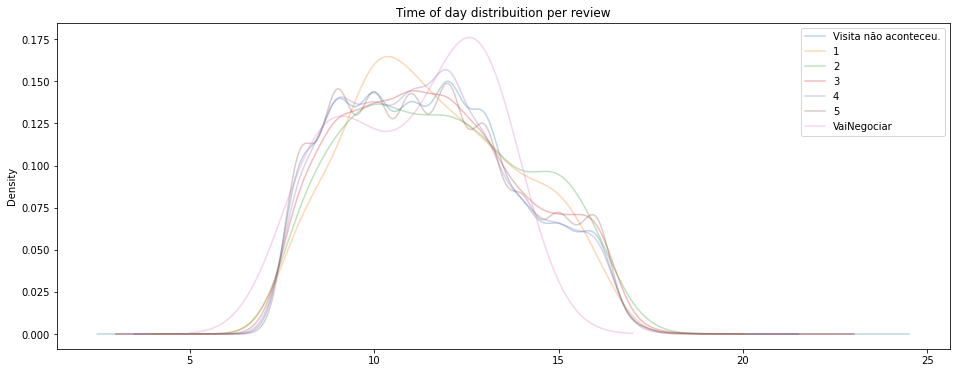

In [16]:
# horario da visita vs review
from datetime import time

#x = pd.Series(range(dftenant_reviews.time.size), index=pd.to_datetime(dftenant_reviews.time).dt.time)


dftenant_reviews['timeh'] = pd.to_datetime(dftenant_reviews.time).pipe(lambda x: x-x.dt.normalize()).astype('timedelta64[h]')

fig, ax = plt.subplots(figsize=(16,6))

dftenant_reviews.groupby('review').timeh.plot.kde(alpha=0.3, ax=ax, title='Time of day distribuition per review')

ax.legend()
plt.show()


In [17]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)

    percentile_.__name__ = "percentile_%s" % n
    return percentile_


# numero médio de visitas por casa
# em média, cada casa foi visitada n vezes por mes
df_visits_per_house = (
    dftenant_reviews.groupby([month, "house_id"])[["total"]]
    .sum()
    .reset_index()
    .groupby("visit_date")
    .total.agg(["min", "mean", "median", percentile(75), percentile(95), percentile(99), "max",])# "count", "var", "std"])
    #.set_index('count', append=True)
)



df_visits_per_house.plot(title='estatística do número de vistas por casa',legend='reverse')
plt.show()

display(df_visits_per_house)

# **3. ideias: analisar/entender o que faz as pessoas voltarem para outras visitas?**
# como aumentar o numero de casas e a qualidade das casas

NameError: name 'np' is not defined